# Codecademy Portfolio Project: "OKCupid Date-A-Scientist"
Project Author: Alexander Lacson

# ! Behind the Scenes

This article is a behind the scenes look at the inspection, cleaning, processing, analysis, and interpretation of the data. If you want to see only the summary of findings, there is a separate article here. View this project's readme for reproducibility information.

# Project Description

In this project, I will work with data from OKCupid, an online dating app. This dataset was provided to me by Codecademy as part of their "Data Science Career Path". In this project I seek to accomplish the following:
- Generate Summary Statistics of OKCupid user profiles.<br> _"Who uses OKCupid and what do they write on their profiles? Which optional information are users more and less likely to share?"_
- Use Machine Learning to predict the values of different features.<br> _"If you were to make a profile, and decide not to fill up all of the optional fields, can we correctly infer what those values might be using Machine Learning?"_
- Use Machine Learning to discover clusters.<br> _"Will Machine Learning reveal different ways users can be classified?"_

Let's begin with inspection of the data.

# Inspection

In [1]:
import pandas as pd
df = pd.read_csv('profiles.csv')
df.info()

FileNotFoundError: [Errno 2] No such file or directory: 'profiles.csv'

- The sample size is 59,946
- There are 30 features to describe each user. Only three of the features are Numeric, the rest are categorical or in text form. 
- Not all users have complete data.

Let's see how these feature values actually look like:

In [ ]:
pd.set_option("display.max_columns", None)
df.head()

- The income column has values of -1 to signify missing values. The other columns make use of NaN.
- I cannot properly see the 'essays' in a tabular display.
- The "last_online" column has values from the year 2012.
- Some of the columns can actually be split up. For example, with the field 'religion', instead of a value being 'agnosticism and very serious about it", we can have {'religion': 'agnosticism'} and {'religion_seriousness': 'very serious about it'}. 

To get a proper idea regarding these essays and columns containing text, let's print out a single user's data.

In [ ]:
def show_user_data(index):
    '''Takes a row index and prints out all the features of that index'''
    for each, col in zip(df.iloc[index], df.columns):
        print('\033[1m' + col + ':' + '\033[0m' + ' ' + str(each))
show_user_data(0)

- The text data is formatted as HTML. This can be converted to normal text using an HTML Parser and Regex.
- After doing some online research, some of the "essays" are the user's continuation of a phrase. For example, an essay question could be "We'll get along if...". The user formulates an essay by continuing that phrase.
- The long text data of the essay questions should probably be analyzed using Natural Language Processing.

To find out how long ago this sample was taken, let's look at the range of values of **last_online**.

In [ ]:
print(df.last_online.min())
print(df.last_online.max())

### "This data is very old. We can only make inference about OKCupid's users during the year 2012!"

Finally, before doing anything to the data, let's see which features have missing values.

In [ ]:
import missingno as msno
msno.matrix(df)
print('Missing values per column')
nulls = [(df[feature].isnull().sum(), feature) for feature in df.columns]
print(sorted(nulls))

- The income column is shown as having no missing values, but in reality it has missing values encoded as "-1".
- Some columns such as age, height, orientation, have no missing values, whereas most of the other columns do have missing values. This means that when a user signs up for OKCupid there are required and optional fields for the user to fill.

## Inspection Recap

In this section we have learned the following:
- The sample size is 59,946
- There are 30 features to describe each user, 3 of which are numeric, the rest are categorical or text
- Users were given Optional and Required fields upon signing up. A lot of users do not supply complete data.
- The income column uses -1 as its placeholder for missing data
- This data sample was collected from the year 2012
- The text data is formatted as HTML
- The essay questions are good candidates for analysis using Natural Language Processing
- Some of the columns can be split up to give us more features

# Cleaning and Tidying

The data has to be cleaned and preprocessed before it can be analyzed. Let's start with replacing the '-1' in the income field with **NaN**, the null value recognized by Pandas and NumPy.

In [ ]:
import numpy as np
df.income.replace(-1, np.nan, inplace = True)

We can reinspect the missing values visualization to confirm the replacement of the null values.

In [ ]:
msno.matrix(df)
print('Missing values per column')
nulls = [(df[feature].isnull().sum(), feature) for feature in df.columns]
print(sorted(nulls))

It appears that income is one of the pieces of information that people would least like to share. Later on, we could make a detailed comparison of the percentage of missing values of each column to evaluate "willingness of users to share information".

Let's move on to the HTML formatted text data. Not only is it more difficult to read, it is also not suitable for Natural Language Processing. Let's clean up the text using an HTML Parser and Regex. I will demonstrate the process when applied to a single entry first.

In [ ]:
from bs4 import BeautifulSoup
import re

#Create html_parser function
def html_parser(raw_html):
    raw_html = str(raw_html)
    soup = BeautifulSoup(raw_html, 'html.parser')
    soup_string = soup.get_text()
    soup_string = re.sub('<.*>', ' ', soup_string)
    return soup_string

**Before:**

In [ ]:
print(df.essay9[0])

**After:**

In [ ]:
print(html_parser(df.essay9[0]))

Now let's apply this to all of the text in the data.

In [ ]:
#Takes a few minutes - Parse all the raw HTML in the data

# import warnings
# warnings.filterwarnings('ignore')

object_cols = [series for series in df.columns if df[series].dtype == 'O']
for series in object_cols:
    df[series] = df[series].apply(lambda row: html_parser(row) if pd.notnull(row) else row)

Lots of warnings given, mostly because users are including YouTube URLs. It's good to be made aware, as the URLs could affect the anlaysis later.

## Cleaning Recap

In this section, we accomplished the following:
- The -1 values of income have been replaced with NaN, making it consistent with the null placeholders used by the other columns, and recognized by Pandas and NumPy
- All HTML formatted text has been converted to normal, readable text. A caveat though is that it still includes '\n', the carriage return symbol, which is parsed by python when the text is input to the print() function.

# Feature Engineering Part 1

Machine Learning can work better if there are more columns because we're giving it more points of comparison. The addition of more columns, also called features, is feature engineering.

I'm going to back up the dataframe in its current form, so that even after modification and addition of columns, we can easily refer to the original data if necessary.

In [ ]:
original_df_backup = df.copy(deep = True)

## Splitting Columns

We can produce new features by splitting the existing ones. Some of our features are actually describing two variables that are potentially independent of each other. Later on, before we develop our model, we will investigate variable codependence by checking Pearson correlations.

### Splitting various columns into two

In [ ]:
def two_split_columns(delimiter, df, feature, col1_name, col2_name, swap = False, stringify_None = False, strip = False):
    '''splits a column into two. Takes a delimiter, DataFrame, and Series name'''
    new = df[feature].str.split(delimiter, n = 1, expand = True) 
    if swap:
        new[1] = new.apply(lambda row: row[0] if not(isinstance(row[1], str)) else row[1], axis = 1)
        new[0] = new.apply(lambda row: '[No Prefix]' if row[0] == row[1] else row[0], axis = 1)
    if stringify_None:
        new[1] = new[1].apply(lambda col: 'None' if col is None else col)
        new[0] = new[0].apply(lambda col: 'None' if col is None else col)
    if strip:
        new[1] = new[1].apply(lambda col: col.strip() if isinstance(col, str) else col)
        new[0] = new[0].apply(lambda col: col.strip() if isinstance(col, str) else col)      
    df[col1_name]= new[0] 
    df[col2_name]= new[1]
    return new

two_split_columns(" ", df, "diet", "diet_adherence", "diet_type", True)
two_split_columns(",", df, "location", "city", "state/country")
two_split_columns(",", df, "offspring", "offspring_want", "offspring_attitude", False, False)
##Religion
df['temp'] = df['religion'].apply(lambda col: col.replace("but", "and") if isinstance(col, str) else col)
two_split_columns("and", df, "temp", "religion_type", "religion_attitude", stringify_None = True, strip = True)
del df['temp']
## Sign
df['temp'] = df['sign'].apply(lambda col: col.replace("but", "and") if isinstance(col, str) else col)
two_split_columns("and", df, "temp", "sign_type", "sign_attitude", stringify_None = True, strip = True)
del df['temp']

Columns split in two:

| Original Feature        | New Feature 1      | New Feature 2|
| :------------- | :---------- | :---------- |
| diet | diet_adherence| diet_type|
| location | city| state|
| offspring | offspring_want| offspring_attitude|
| religion | religion_type| religion_attitude|
| sign | sign_type| sign_attitude|

### Splitting 'pets'

There are really two kinds of pets among the values: dogs and cats. Let's proceed by splitting 'pets' into 'dogs' and 'cats'.

In [ ]:
temp = two_split_columns("and", df, "pets", "dogs", "cats", False, False, strip = True)
temp[1] = temp.apply(lambda row: row[0] if "cat" in str(row[0]) else row[1], axis = 1)
temp[0] = temp.apply(lambda row: None if "cat" in str(row[0]) else row[0], axis = 1)
df["dogs"] = temp[0]
df["cats"] = temp[1]

Having a pet can have nothing to do with liking a pet. Let's  further split this into 'dog_preference', 'has_dogs', 'cat_preference', 'has_cats'. Let's also remove 'dogs' and 'cats'.

In [ ]:
df['dog_preference'] = df.apply(lambda row: row['dogs'] if "like" in str(row['dogs']) else None, axis = 1)
df['cat_preference'] = df.apply(lambda row: row['cats'] if "like" in str(row['cats']) else None, axis = 1)
df['has_dogs'] =  df.apply(lambda row: 1 if "has" in str(row['dogs']) else 0, axis = 1)
df['has_dogs'] =  df.apply(lambda row: row['has_dogs'] if isinstance(row['pets'], str) else None, axis = 1)
df['has_cats'] =  df.apply(lambda row: 1 if "has" in str(row['cats']) else 0, axis = 1)
df['has_cats'] =  df.apply(lambda row: row['has_cats'] if isinstance(row['pets'], str) else None, axis = 1)
del df['dogs']
del df['cats']

In [ ]:
df[['dog_preference', 'has_dogs', 'cat_preference', 'has_cats']].head()

### Splitting 'speaks'

There's quite some unpacking that needs to be done here. There appear to be several different languages and different options for fluency. Before we start making new columns, let's get a better sense for what exactly our values are.

In [ ]:
languages = df.speaks.value_counts()
languages = languages.index
languages = [each.split(',') for each in languages]
languages = [item for sublist in languages for item in sublist]
languages = set([each.strip() for each in languages])
temp = languages
languages = [each.split(" (") for each in languages]
languages = [each[0] for each in languages]
languages = sorted(set(languages))
print("There are {} different language options:".format(len(languages)))
print(languages)
print("There are 4 different fluency options per language:")
print(sorted(temp)[:4])

After isolation of terms it is revealed that among the 'speaks' values there are 77 different languages and four different descriptors of language fluency. The ambiguity of the fluency options presents a dilemma. What is 'afrikaans' supposed to mean compared to 'afrikaans (okay)'? Because of this ambiguity, we will not make use of the fluency descriptors in our visualization. We will create a new column for each language containing a 1 to indicate if the language is spoken, 0 if not. The result is actually called a sparse matrix. 'Sparse' because it contains much more 0s than 1s.

In [ ]:
#Takes a few minutes
for language in languages:
    df[language] = df.apply(lambda row: 1 if (language in str(row['speaks'])) else 0, axis = 1)

In [ ]:
df[languages].head(3)

Print memory usage function. Let's investigate the memory being used up by the sparse matrix.

In [ ]:
#Credit where credit is due: Function from Dafni Sidiropoulou Velidou's article "Working with sparse data sets in pandas and sklearn"
BYTES_TO_MB_DIV = 0.000001
def print_memory_usage_of_data_frame(df):
    mem = round(df.memory_usage().sum() * BYTES_TO_MB_DIV, 3) 
    print("Memory usage is " + str(mem) + " MB")
    
print_memory_usage_of_data_frame(df[languages])

In [ ]:
df.languages.info()

Converting our sparse matrix to a Pandas Sparse Array reduces its memory usage and allows AI algorithms to take less time training on it.

In [ ]:
temp = df[languages].copy()
for (columnName, columnData) in temp.iteritems():
    df[columnName] = pd.arrays.SparseArray(columnData.values, dtype='uint8')

print_memory_usage_of_data_frame(df[languages])

## Adding columns

There are other ways to derive new features in addition to splitting.

In [ ]:
temp = df['ethnicity'].apply(lambda col: col.split(",") if isinstance(col, str) else col)
df['num_ethnicities'] = temp.apply(lambda col: len(col) if isinstance(col, list) else col)
df['optional_%unfilled'] = ((original_df_backup.isnull().sum(axis = 1))/24) * 100
df['num_languages'] = df[languages].sum(axis = 1).replace(0, None)

Added Columns:

| New Feature        | Description      |
| :------------- | :---------- |
| num_ethnicities |Contains the number of ethnicities listed in 'ethnicity'|
| optional_%unfilled |Percentage of optional fields unfilled|
| num_languages|Count of languages spoken|

**Note to self: Try adding Total essay response length per user. The sum of the lengths of all the essays.**

## Feature Engineering Part 1 Recap

In this section, we accomplished the following:
- We split the following columns into two:

| Original Feature        | New Feature 1      | New Feature 2|
| :------------- | :---------- | :---------- |
| diet | diet_adherence| diet_type|
| location | city| state|
| offspring | offspring_want| offspring_attitude|
| religion | religion_type| religion_attitude|
| sign | sign_type| sign_attitude|

- We split 'pets' into 'dog_preference', 'has_dogs', 'cat_preference', 'has_cats'
- We expanded 'speaks' into a boolean matrix where each column is a language and each row value is 1 or 0
- We introduced the following additional columns:

| New Feature        | Description      |
| :------------- | :---------- |
| num_ethnicities |Contains the number of ethnicities listed in 'ethnicity'|
| optional_%unfilled |Percentage of optional fields unfilled|
| num_languages|Count of languages spoken|

# Visualization

## Numerical Features

The best way to explore data is to visualize it. Let's start by generating histograms and boxplots of our numerical features.

In [ ]:
import plotly.express as px

selection = ['age', 'height', 'income', 'optional_%unfilled']
fig = px.histogram(df, x = selection, marginal = 'box', histnorm = 'percent').update_traces(visible = False, showlegend=False)
fig.data[0].visible = True
fig.data[1].visible = True

def create_button(column):
    temp = []
    for each in selection:
        temp.append(each == column)
        temp.append(each == column)
    return dict(
                args=[{"visible": temp}],
                label=column,
                method="update"
                )

fig.update_layout(
    title = "2012 OKCupid Profiles",
    updatemenus=[
        #Add a dropdown selector
        dict(
            buttons = [create_button(column) for column in selection],
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
        )

    ]
)
fig.show()

Use the dropdown selector to switch between features. Datapoints show more information on mouseover. The graph can be panned and zoomed.

| Feature        | Comment      |
| :------------- | :---------- |
| Age | The median age is 30. The distribution is right-skewed. Most users are young and working adults.|
|  Height        | Most heights range between 59 and 78 in (4.9 - 6.5 ft) with a median of 68in(5.67ft). The distribution appears normal. |
|  Income        | The median income is \\$50k. A quarter of all incomes are $25k. Most income distributions are log-normal (if the ultra-wealthy are not included), and this is no different. |
|All Features Above| From the box plot, we can see that all of the distributions have outliers - There is a 4.5% group of \\$1M earners. There are two people over 100 years old. There is a height of 1in. Below, we will inspect these data points (user profiles) to see what's really going on.|
|optional_%unfilled| The y-axis shows the percentage of users and the x-axis shows the percentage of optional user information fields left unfilled. Interquartile Range is 12% - 30%, meaning half of all users don't bother to fill 12% - 30% of optional fields. A quarter of users are below that range and a quarter of users are above that range. This is a feature that was engineered from the given raw data.|

### Outlier Inspection

#### Age

Let's look a look at the profiles of our centennial users.

In [ ]:
display(df.iloc[2512:2513])
display(df.iloc[25324:25325])

The first one has 95% unfilled optional fields. The second has 54% unfilled optional fields and a height of 95inches(8ft tall). Do you think these profiles are reliable?

#### Height

Below is an example of the kind of user profile which 'has a height of 1 inch'.

In [ ]:
show_user_data(45959)

#### Income

Below is the profile of someone who has an income of \$1M.

In [ ]:
show_user_data(27590)

Graduated from space camp, complains about OKCupid picture takedown in essay0, nine ethnicities, five languages, 5' 10" in height. Do you think this income is reliable?

### Decision on Outliers Option A

We will keep all outliers in this analysis. We do not have any data on actual user information beyond what they have shared on their profiles. We will not make any inference as to the statistics of actual user demographics. Only inference and insight about what profiles exist and are represented on the platform.<br><br>
We do have confirmation that the user profiles are not 100% reliable reflections of real-world user demographics. The interpretation of our predicitive models, in the later sections, will only try to predict what a user might write, as opposed to actually predicting a user's real-world characteristics and information.

### Decision on Outliers Option B

We will remove outliers for _age_ and _height_. Outliers have the potential to greatly increase memory usage, variance, and training time. The current objective is to make a predictive model that works. If that objective is accomplished, we have the option of reiterating on this project to incorporate outliers.

In [ ]:
df = df[(df['height'] >= 57) & (df['height'] <= 80) & (df['age'] <= 69)]

## Categorical Features

### Interactive Treemap (only interactive if opened with Jupyter Notebooks and required packages are installed)

In [ ]:
from ipywidgets import interact, fixed

def make_treemap(df, feature, dropna):
    counts_table = df[feature].value_counts(normalize = True, dropna = dropna).reset_index()
    counts_table.rename(columns={feature: 'Percent'}, inplace = True)
    counts_table['Percent'] = counts_table['Percent'] * 100
    if dropna:
        names = 'index'
    else:
        names = counts_table['index'].apply(str)
    fig = px.treemap(
        counts_table,
        parents = [feature] * len(counts_table), #Need to define a tree root
        names = names,
        values = 'Percent',
        title = '2012 OKCupid Profiles',
        color = 'Percent',
        color_continuous_scale='Blues'
    )
    fig.update_traces(marker_showscale=False, texttemplate='%{label}<br>%{value:.2f%}%')
    fig.show()
    
essay_feats = ['essay0','essay1','essay2','essay3','essay4','essay5','essay6','essay7','essay8','essay9',]
numerical_feats = ['age', 'height', 'income']
drop_list = essay_feats + numerical_feats + ['last_online']
interact(make_treemap, df = fixed(df), feature = [each for each in df.columns if each not in drop_list], dropna = False)

An interactive tool for visualizing the categorical features as a treemap. The dropdown selector allows us to choose the feature to display, and the tickbox allows us to choose whether to include NaN values in the treemap.

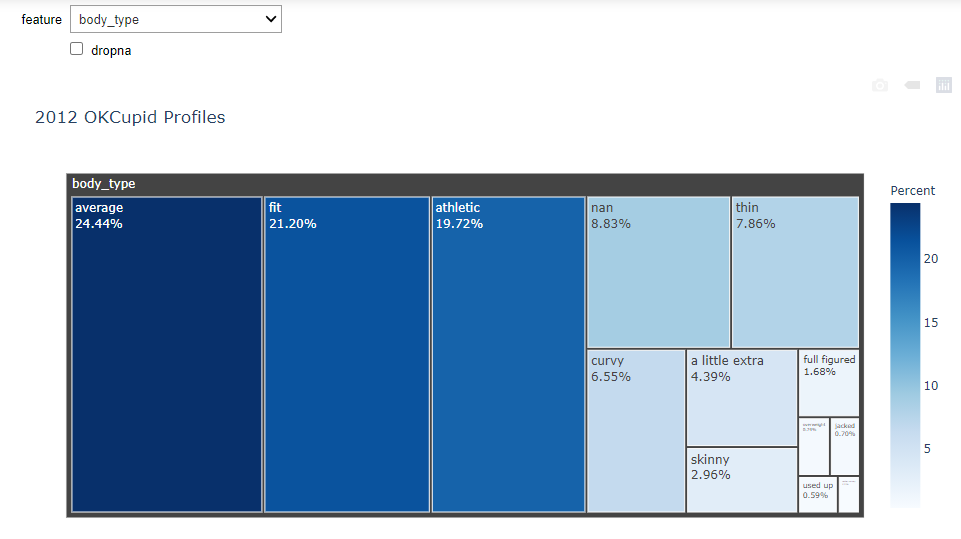

### Dashboard style donut plot grid of variables

In [ ]:
print('**Nan represents unfilled/unshared optional information, \
signifiying that a user has not shared the\n respective information with OKCupid and it\'s missing from their profile')
import matplotlib.pyplot as plt

drop = ['diet', 'diet_adherence', 'location', 'offspring_want', 'offspring_attitude', 'pets', 'religion', 'sign', 'speaks',
        'religion_attitude', 'sign_attitude', 'optional_%unfilled',
        'last_online'] + languages + ['age', 'height', 'income'] + essay_feats
for_plotting = df.drop(columns = drop).columns.to_list()
extrapolated_vars = ['diet_type', 'city', 'state/country', 'religion_type', 'sign_type',
                     'dog_preference', 'has_dogs', 'cat_preference', 'has_cats', 'num_ethnicities', 'num_languages']

def collapse_category(feat, threshold):
    '''Needed to ensure that only a mask would be used to mark categories to collapse,
    and to preserve the original data frame'''
    sum = df[feat].value_counts(dropna = False).reset_index()[feat].sum()
    temp = df[feat].copy()
    mask1 = temp.value_counts()/sum < threshold
    mask2 = temp.isin(mask1[mask1 == True].index)
    temp[mask2] = 'other'
    return temp.value_counts(dropna = False).reset_index()


for i in range(1, 12):
    plt.figure(figsize = (16, 9))
    j = 2*i
    k = j-2
    for num, feat in zip(range(1,3), for_plotting[k:j]):
        plt.subplot(1, 2, num)
        temp = collapse_category(feat, 0.01)
        labels = temp['index']
        theme = plt.get_cmap("tab20" if len(labels) > 10 else "tab10")
        plt.pie(x=temp[feat], autopct="%.1f%%", labels=labels, pctdistance=0.77,
                #radius = 1,
                colors = theme(np.arange(len(labels))),
                wedgeprops=dict(width=0.10,
                                edgecolor="k",
                                linewidth=0.7))
        text = feat + '*' if feat in extrapolated_vars else feat
        plt.text(0, 0, text, 
                 horizontalalignment = 'center',
                 verticalalignment = 'center',
                 fontsize = 20)
    plt.show()
    plt.clf()
print('\033[1m'+'*Extrapolated or split from raw data variables'+'\033[0m')

**Bias:**

The biggest indicator that this sample does not meet the statistical criteria for independent random sampling is the 'state/country' variable. OKCupid was founded in 2004. It's simply not possible that by 2012 all of their users would only be from the state of California. When you get a dataset, regardless of what you've been told about the quality of the sampling, always check for signs of bias. The process of checking for bias in a study or in a sample is sometimes called a "Risk of Bias Assessment".

Even though the sample looks like it's heavily biased, we will still draw inference about what is represented in the sample.

**The charts tell us that the typical profile on OKCupid is:**
- not fat or skinny
- has drinks socially
- doesn't do drugs
- finished college
- white ethnicity
- varied in terms of possible job background
- doesn't have kids
- straight
- male
- doesn't smoke
- single
- lives in San Francisco, California
- eats anything
- agnostic or atheist
- likes dogs and/or cats but doesn't have them
- not multiracial
- speaks only one language

It's possible that people misrepresent themselves on their profile, paint themselves more positively, and carefully omit negative information.

### Top Spoken Languages

In [ ]:
import seaborn as sns

lang_percent = []
for language in languages:
    lang_percent.append((language, df[language].value_counts(normalize = True).loc[1]))
    
def sort_func(pair):
    return pair[1]    
sorted_lang_percent = sorted(lang_percent, key = sort_func, reverse = True)

#Make barplot
plt.figure(figsize = (16, 9))
rects = sns.barplot(x = [each[1] for each in sorted_lang_percent[:10]],
            y = [each[0].title() for each in sorted_lang_percent[:10]], 
            orient = 'h',
            palette = "tab20")

#Add Data Labels outside of bar
rect_labels = []
for rect in rects.patches:
    yloc = rect.get_y() + rect.get_height() / 2
    label = plt.annotate(format(rect.get_width(), '.1%'), xy=(rect.get_width(), yloc), xytext=(4, 0),
                         textcoords="offset points", horizontalalignment='left', verticalalignment='center',
                         color='black', clip_on=True)
    rect_labels.append(label)

plt.title("Top 10 Languages")
plt.ylabel("Language")
plt.xlabel('% of users who speak it'.title())
plt.show()

Everyone speaks English. Hilariously some people speak C++... _why not Python?_

##  Unfilled Optional Fields Sorted

In [ ]:
sorted_nulls = sorted(nulls, reverse = True)
sample_size = 59946

#Make barplot
plt.figure(figsize = (16, 9))
rects = sns.barplot(x = [each[0]/sample_size for each in sorted_nulls[:23]],
            y = [each[1].title() for each in sorted_nulls[:23]], 
            orient = 'h',
            palette = "tab20")

#Add Data Labels outside of bar
rect_labels = []
for rect in rects.patches:
    yloc = rect.get_y() + rect.get_height() / 2
    label = plt.annotate(format(rect.get_width(), '.2%'), xy=(rect.get_width(), yloc), xytext=(4, 0),
                         textcoords="offset points", horizontalalignment='left', verticalalignment='center',
                         color='black', clip_on=True)
    rect_labels.append(label)

plt.title("Unfilled Optional Fields")
plt.ylabel("Fields")
plt.xlabel('% of users who did not give information'.title())
plt.show()

**Disclaimer**: My comments below are pure speculation and hypothesis

| Feature        | Hypothesis For Not Sharing Information     |
| :------------- | :---------- |
| Income |If you're rich you don't want the IRS to know. If you're poor, you don't want potential matches to see that either|
| Children |Finding out someone has kids can be a turn off and perceived as extra baggage|
| Diet|People are afraid of being criticized for choosing to shun some foods|
|Religion|Some people are xenophobic. As a result, some people hide their religion so as not to immediately turn away those xenophobes|
|Pets| No idea why a third of users don't share this information|
|Essays| There's a pattern where the higher up the chart you go, the higher the essay number. This is because the questions are presented to the user in a fixed order. Not all users have the patience to answer questions all the way to the last one. The reason why essay 8 stands out significantly more than the rest is because the question being asked is "Share something private", which of course is rather controversial considering you can't take back what you share online. See below [section](#Interpretation-of-tf-idf-Results) for the essay questions.|
|Drugs|Drugs are illegal in some states|

## Essay Questions

The essay questions are a perfect candidate for Natural Language Processing (NLP) Topic Modelling. More specifically, we'll be using term frequency - inverse document frequency (tf-idf), a model which initially counts the occurences of each word, then applies a word weighting scheme which deprioritizes common words such as "the". The expected result is to condense the essay answers into specific keywords, which may be visualized.

Let's create a copy of all of the essay answers ,just in case we need to start over in the preprocessing for NLP.

In [ ]:
nlp_essay_df = df[essay_feats].copy(deep = True)

### Text Preprocessing

Before we can apply tf-idf to our essay questions, we need to convert them to a suitable format. The process is called text preprocessing. The words of our essay questions will be converted to their root words(also called lemma).

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

from collections import Counter
import unicodedata
import string

# Lemmatizer class object - converts tokens to root words
lemmatizer = WordNetLemmatizer()
# Fetch nltk stopwords
stopwords = nltk.corpus.stopwords.words('english')

def preprocess_corpus(DataFrame, Series):
    # Remove accents function
    def remove_accents(data):
        return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")

    # Look at synonyms of the word if it's likely to be a noun, verb, adjective, or adverb
    def get_part_of_speech(word):
        # Fetch synonyms of word from wordnet database
        probable_part_of_speech = wn.synsets(word)
        # Count the number of nouns, verbs, adjectives, and adverbs among the synonyms
        pos_counts = Counter()
        pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
        pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
        pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
        pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
        # Get the speech type with the highest count and return it
        most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
        return most_likely_part_of_speech

    # Convert each word into its lemma(root word)
    def preprocess_text(text, min_word_length):
        # Tokenize
        tokens = nltk.word_tokenize(text)
        # Convert to lowercase
        tokens = [token.lower() for token in tokens]
        # Remove accents
        tokens = [remove_accents(token) for token in tokens]
        # Remove punctuations
        tokens = [str(token).translate(string.punctuation) for token in tokens]
        tokens = [token for token in tokens if token != '']
        # Remove stopwords
        tokens = [token for token in tokens if token not in stopwords]
        # Remove short words
        tokens = [token for token in tokens if len(token) >= min_word_length]
        # Lemmatize
        lemmas = " ".join([lemmatizer.lemmatize(token, get_part_of_speech(token)) for token in tokens])
        return lemmas
    
    # Convert Data Series to a List 
#     list_corpus = DataFrame[Series].dropna().to_list()
    list_corpus = DataFrame[Series].to_list()
    # Remove linebreaks
    list_corpus = [" ".join(text.splitlines(False)) if isinstance(text, str) else ' ' for text in list_corpus ]
    # Remove '/' characters
    list_corpus = [text.replace('/', ' ') if isinstance(text, str) else ' ' for text in list_corpus]
    #Normalize
    processed_corpus = [preprocess_text(text, 3) if isinstance(text, str) else ' ' for text in list_corpus]
    return processed_corpus

### Term Frequency-Inverse Document Frequency

Now that we have our root words, let's apply tf-idf. It will assign a score to each root word. For each user's answer we will get the highest scoring word (keyword). This keyword represents what our model believes is the most significant word of a user's response.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Tfidf class object - Scores each word
vectorizer = vectorizer = TfidfVectorizer()

def tfidf_for_keywords(processed_corpus):
    '''Generates one keyword for each document in the corpus. Returns all keywords as a list.'''
    tfidf_scores = vectorizer.fit_transform(processed_corpus)
    feature_names = vectorizer.get_feature_names()
    keywords = [feature_names[row.argmax()] for row in tfidf_scores]
    return keywords, tfidf_scores, feature_names

### Iterate over all essay columns

Let's iterate the whole process over all of our essay features, and let's collect only the most common keywords.

In [ ]:
essay_vectors = []
essay_feature_names = []
def series_to_keywords(DataFrame, Series, n_top, export_vectors = False):
    processed_corpus = preprocess_corpus(DataFrame, Series)
    keywords, tfidf_scores, feature_names = tfidf_for_keywords(processed_corpus)
    essay_vectors.append(tfidf_scores)
    essay_feature_names.append(feature_names)
#     temp = DataFrame[Series].dropna().reset_index()
    temp = DataFrame[Series].reset_index()
    temp[str(Series) + '_keywords'] = keywords 
    if export_vectors:
        temp[str(Series) + '_keywords'].value_counts().iloc[:n_top].to_csv(str(Series) + '_top_keys.csv')

for feature in essay_feats:
    series_to_keywords(nlp_essay_df, feature, 40)

In [ ]:
essay_vectors[2].get_shape()

### Top Keywords in User Responses to Essay Questions Visualized as Wordclouds

Let's generate wordclouds for each of the essay questions. <br>
_Developer Note: The code is embedded as an image because it was run in a separate Python 3.7 environment._

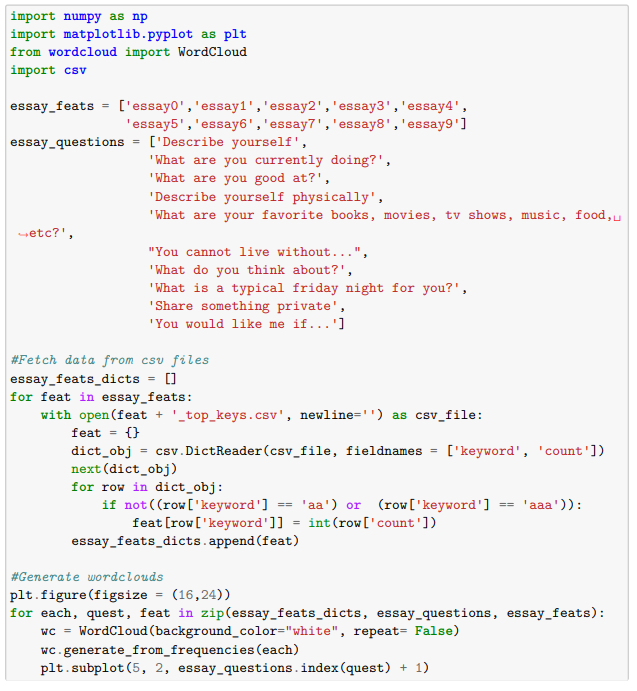

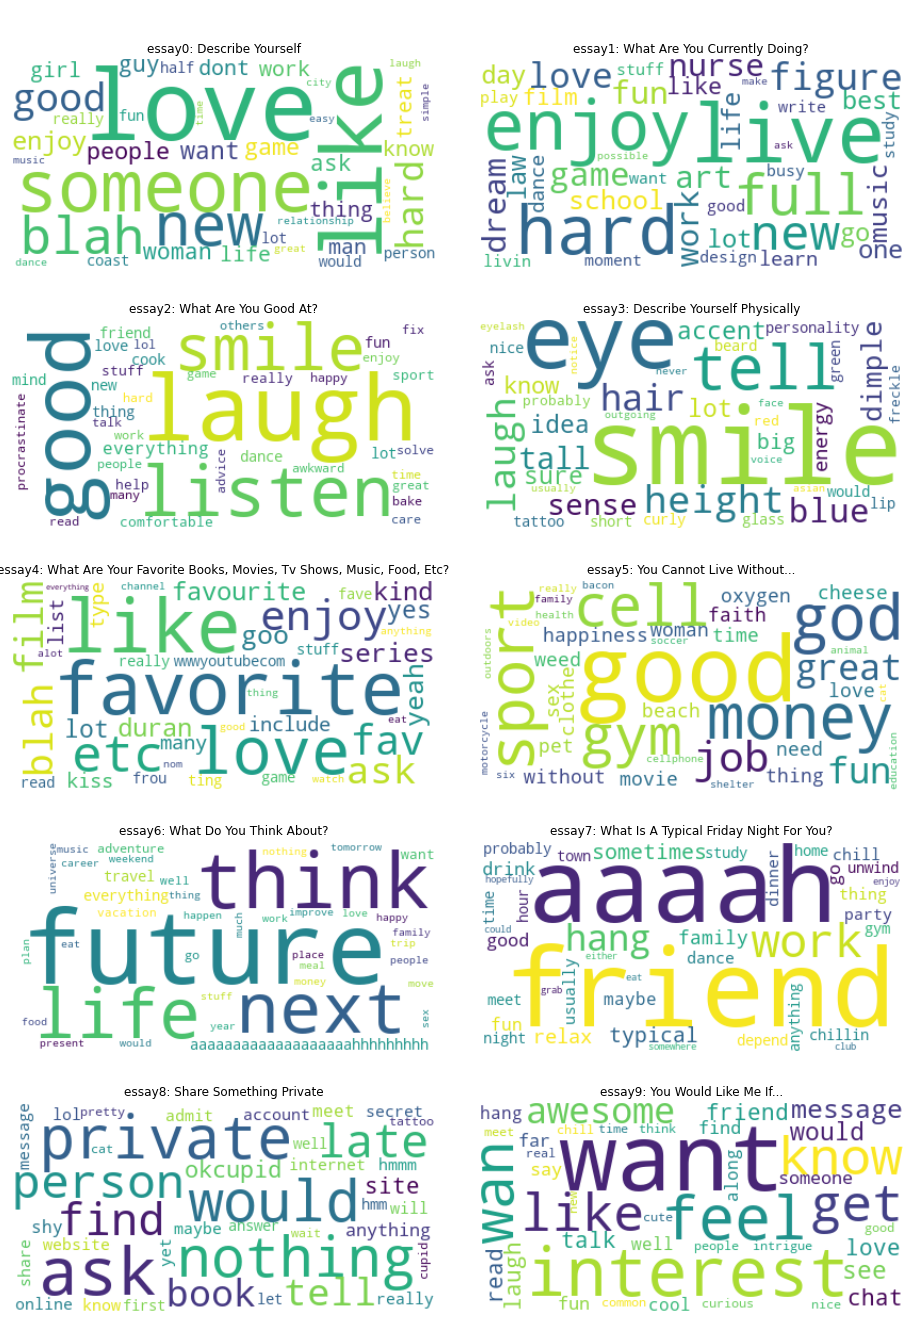

The level of insight gained from each wordcloud, using the existing model algorithm, is not the same. Some give sufficiently interesting and useful results. Some tell us more about what essay question is being asked rather than what the answers to those questions are. The results merit further filtering, tweaking, and refinement of the algorithm to give us better keywords. Further NLP modelling and analysis deserves to be discussed in its own lengthy separate article/notebook. We will not explore it further here.

In addition to the wordclouds, manual reading of several user responses was done to better interpret the tf-idf results.

### Interpretation of tf-idf Results

|Essay Number| Personal best guess of the question asked| Comment on tf-idf Result|
| :------------- | :---------- | :---------- |
|essay 0| Describe yourself| Users use this essay question to talk about what they like, love, and the qualities of who(someone) they're looking for|
|essay 1| What are you currently doing?| A lot of the smaller words are clear answers to the question while the biggest words are a little bit more difficult to interpret or could be weighted to have a lower score| 
|essay 2| What are you good at?| Users say they're good at listening and that they have a great smile and laugh|
|essay 3| Describe yourself physically| Users talk about their eyes, hair, smile, and height|
|essay 4|What are your favorite books, movies, tv shows, music, food, etc | Not a very meaningful result. More useful for guessing the essay question.|
|essay 5| You can't live without...|Users cannot live without their cellphone, money, gym, job, god, sports, fun. Not sure though what it means that 'good' is top keyword|
|essay 6| What do you think about?| Users think about life and the future|
|essay 7| What is a typical friday night for you?| Users are with their friends on friday nights|
|essay 8| Share something private| Users say 'message/ask me about private things and ill share it with you, but I won't share it here on my public profile'. From the previous section, we can also see that this is the least answered essay question.|
|essay 9| You would like me if...| Doesn't seem like a very meaningful result|

### Further NLP Practice

There is still additional NLP analysis that we will not explore here but can definitely be applied. For example, we can see in essay0 the top keywords are 'love' and 'like'. _What do users really mean when they use the word 'love'? Is it 'making love' or 'looking for love'? Are they using 'love' and 'like' interchangeably?_

Additional NLP:
- Filter keywords by Part of Speech (noun, adjective, verb, adverb)
- Contextualize keywords by investigating the words which follow and precede them
- Make use of n-grams instead of one-word terms. The terms in our tf-idf model are one word long, but we can also use pairs of words, or groups of three words, and even more. You could also try skip-grams.
- Make use of other Word Embedding Models, an AI model that maps words into vectors. Tf-idf was only one example of a simple word embedding model. Each element of the vector could be different properties of the word, such as its part of speech, number of syllables, number of vowels, number of consonants, what word follows it, what word precedes it, location of the word in the paragraph, and much more. 
- Input the tf-idf results to a Latent Dirichlet Allocation (LDA) Model. Manually assign labels to your LDA topics. Plot the most common topics in the corpus, as well as the most common words per topic,  from your LDA result.

## Visualization Recap

**In this section, we visualized the following:**
- We visualized our numerical features using box plots and histograms
- We made an interactive treemap of our categorical features
- We visualized our categorical features using donut plots
- Using bar plots we visualized the top spoken languages and top unfilled optional fields among user profiles
- We visualized the essay question responses using Natural Language Processing and wordclouds

**From our Numerical Features we learned:**

| Feature        | Comment      |
| :------------- | :---------- |
| Age | The median age is 30. The distribution is right-skewed. Most users are young and working adults.|
|  Height        | Most heights range between 59 and 78 in (4.9 - 6.5 ft) with a median of 68in(5.67ft). The distribution appears normal. |
|  Income        | The median income is \\$50k. A quarter of all incomes are $25k. Most income distributions are log-normal (if the ultra-wealthy are not included), and this is no different. |
|optional_%unfilled| Half of all users don't bother to fill 12% - 30% of optional fields. A quarter of users are below that range and a quarter of users are above that range.|

**From our Categorical Features we learned the stereotypical profile is:**
- not fat or skinny
- has drinks socially
- doesn't do drugs
- finished college
- white ethnicity
- varied in terms of possible job background
- doesn't have kids
- straight
- male
- doesn't smoke
- single
- lives in San Francisco, California
- eats anything
- agnostic or atheist
- likes dogs and/or cats but doesn't have them
- not multiracial
- speaks only one language

We also discovered that our sample has a high risk of bias. In our sample data which is dated from 2012, although OKCupid was founded in 2004, practically everyone lives in California and half of that in the City of San Francisco.

**With the use of bar plots we learned:**
- Everyone speaks English
- Among the information users don't want to share, 'income' is the highest, with an 80% overwhelming majority, followed by 'offspring'(whether they have children) at 60%.

**From our Essay Features we learned:**

|Essay Number| Personal best guess of the question asked| Comment on tf-idf Result|
| :------------- | :---------- | :---------- |
|essay 0| Describe yourself| Users use this essay question to talk about what they like, love, and the qualities of who(someone) they're looking for|
|essay 1| What are you currently doing?| A lot of the smaller words are clear answers to the question while the biggest words are a little bit more difficult to interpret or could be weighted to have a lower score| 
|essay 2| What are you good at?| Users say they're good at listening and that they have a great smile and laugh|
|essay 3| Describe yourself physically| Users talk about their eyes, hair, smile, and height|
|essay 4|What are your favorite books, movies, tv shows, music, food, etc | Not a very meaningful result. More useful for guessing the essay question.|
|essay 5| You can't live without...|Users cannot live without their cellphone, money, gym, job, god, sports, fun. Not sure though what it means that 'good' is the top keyword|
|essay 6| What do you think about?| Users think about life and the future|
|essay 7| What is a typical friday night for you?| Users are with their friends on friday nights|
|essay 8| Share something private| Users say 'message/ask me about private things and ill share it with you, but I won't share it here on my public profile'. From the previous section, we can also see that this is the least answered essay question.|
|essay 9| You would like me if...| Doesn't seem like a very meaningful result|


**In this section, we made the decision to keep all outliers:**<br><br>
We are aware that some profiles do not contain reliable information about a user in the real world, but these outliers may be used to predict what a new user might write when making a new profile.<br>

**In this section, we made the decision to strip outliers of _age_ and _height_:**<br><br>
Outliers have the potential to increase memory usage, variance, and training time. The current objective is to make a predictive model that works. If that objective is accomplished, we have the option of reiterating on this project to incorporate outliers.

# Feature Engineering Part 2

We need to do even more feature engineering before we go into Machine Learning. All our features have to be properly formatted and expanded/encoded. Any value that is not a number will not be understood by out ML training algorithm.

We will make a backup copy of our data at this point, so that we can reset back to this checkpoint if we want to undo any modifications. Let's also drop our languages sparse matrix. Previously we didn't include the fluency descriptors in our sparse matrix for our visualization. Later, when one-hot encoding, we will make a new sparse matrix for languages which contains the fluency descriptors.

In [ ]:
expanded_df_backup = df.drop(columns = languages).copy(deep = True)

In [ ]:
df = expanded_df_backup.copy(deep=True)

Let's convert _last_online_ from a string to a datetime format and split it up.

In [ ]:
df['last_online'] = pd.to_datetime(df.last_online, format = "%Y-%m-%d-%H-%M")
df['last_online_year'] = df.last_online.dt.year
df['last_online_month'] = df.last_online.dt.month
df['last_online_day'] = df.last_online.dt.day
df['last_online_hour'] = df.last_online.dt.hour

Let's drop columns that we have created splits from. If we need to use them as target variables for prediction we can recover any of them from our backup dataframe. Let's drop _income_ because 80% of it's values are missing. Let's also drop _num_ethnicities_ and _optional__%unfilled_.

In [ ]:
df = df.drop(columns = ['diet', 'location', 'offspring', 'religion', 'sign', 'pets', 'income', 'last_online',
                        'num_ethnicities', 'optional_%unfilled'])

Let's apply one-hot encoding to our categorical variables. We will also encode a category to represent the null values of each feature, so that our ML model will include the user's decisions to share particular information when making predictions.

In [ ]:
print('Before one-hot encoding:')
df.info()

In [ ]:
df = pd.get_dummies(df, columns = ['body_type', 'drinks', 'drugs', 'education', 'job', 'orientation', 'sex',
                                           'smokes', 'status', 'diet_adherence', 'diet_type', 'city', 'state/country',
                                           'offspring_want', 'offspring_attitude', 'religion_type', 'religion_attitude', 
                                           'sign_type', 'sign_attitude', 'dog_preference', 'cat_preference', 'has_dogs',
                                           'has_cats',], 
                    sparse=True,
                    dummy_na=True)

df.rename(columns = {'sex_m':'sex'}, inplace = True)
df = df.drop(columns = ['sex_f'])

def string_dummies(df, series, sep):
    if df[series].isna().any():
        df[series + '_nan'] = df[series].isna().astype('int64')
    temp_df = df[series].str.get_dummies(sep).add_prefix(str(series) + '_')
    df = pd.concat([df, temp_df], axis = 1)
    return df.drop(columns = [str(series)])

selection = ['ethnicity', 'speaks']
sep_list = [', ', ', ']
for series, sep in zip (selection, sep_list):    
    df = string_dummies(df, series, sep)

In [ ]:
print('After one-hot encoding:')
df.info()

Let's make our dataframe have uniform datatypes. Just ignore the datatype of the essays for now (the ten object coumns).

In [ ]:
df['height'] = df.height.astype('int64')
for each in df.select_dtypes(include=['int64']).columns.to_list():
    df[each] = pd.arrays.SparseArray(df[each].values, dtype='uint8')
df.info()

At this point, the only features in our dataframe that are not ready for feeding into an ML training algorithm are our essay features. The tf-idf scores for each essay that we made previously serve as the vector representation of the essays. This is a format that an ML algorithm can already train on. However, our essay vectors are of a type known as **Compressed Sparse Row Matrix** (csr_matrix), while our other features are of type **DataFrame**. If we want to have the capability of training on our essay features and our other features at the same time, we will have to convert all features to the same data type. Let's convert our dataframe to a csr_matrix in order to match our essay vectors. Training is faster and less memory is used with a csr_matrix instead of a DataFrame. But first, let's drop our unvectorized essay features from the dataframe.

In [ ]:
print(df.shape)
df.dropna().shape

In [ ]:
df.select_dtypes(include = ['object']).columns.to_list()

In [ ]:
feature_correlations = df.corr()

In [ ]:
feature_correlations.head()

# Predictive Model using Supervised Machine Learning

In [ ]:
from sklearn.linear_model import LogisticRegression
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import time

In [ ]:
sparse_essay_df = df.copy(deep = True)

In [ ]:
#Select predictors and target
categorical_feats = []
cat_selection = ['body_type', 'drinks', 'drugs', 'education', 'job', 'orientation',
                'smokes', 'status', 'diet_adherence', 'diet_type', 
                'offspring_want', 'offspring_attitude', 'religion_type', 'religion_attitude', 
                'sign_type', 'sign_attitude', 'dog_preference', 'cat_preference', 'has_dogs',
                'has_cats', 'ethnicity', 'speaks']

for each in cat_selection:
    categorical_feats = categorical_feats + sparse_essay_df.loc[:, sparse_essay_df.columns.str.startswith(each)].columns.to_list()
predictors = sparse_essay_df[categorical_feats + ['age', 'height']].sparse.to_dense()
# predictors = predictors.sparse.to_coo()
# predictors = predictors.tocsr()
target = sparse_essay_df.sex

X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size = 0.2)

# Scale the feature data so it has mean = 0 and standard deviation = 1
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Create and train the model
model = LogisticRegression()
model.fit(X_train, y_train)

print('Train score: ' + str(model.score(X_train, y_train)))
print('Test score: ' + str(model.score(X_test, y_test)))

In [ ]:
# Analyze the coefficients
colors = ['Male Predictor' if c > 0 else 'Female Predictor' for c in model.coef_[0]]

fig = px.bar(
    y=predictors.columns,
    x=abs(model.coef_[0]), 
    color=colors,
    color_discrete_sequence=['red', 'blue'],
    labels=dict(x='Predictor', y='Linear coefficient'),
    title='Top 20 predictors',
)
fig.update_yaxes(categoryorder = "total ascending", range=(len(predictors.columns) - 20.6, len(predictors.columns)))
fig.show()

In [ ]:
from sklearn.linear_model import LinearRegression

def train_a_model(target_var):
    start = time.time()

    sparse_essay_df = df.copy(deep = True)
    sparse_essay_df = sparse_essay_df.drop(columns = sparse_essay_df.select_dtypes(include = ['object']).columns.to_list())

    target_vars = sparse_essay_df[target_var]
    feature_vars = sparse_essay_df.drop(columns = [target_var])
    feature_vars = feature_vars.sparse.to_coo()
    feature_vars = feature_vars.tocsr()
    print(feature_vars.get_shape())
    print(essay_vectors[0].get_shape())
    for vector in essay_vectors:
        feature_vars = hstack([feature_vars, vector])
    print(feature_vars.get_shape())

    target = target_vars
    features = feature_vars
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2)
    model = LinearRegression()
    model.fit(X_train, y_train)
    print('Train score: ' + str(model.score(X_train, y_train)))
    print('Test score: ' + str(model.score(X_test, y_test)))
    y_predicted = model.predict(X_test)
    dense_y_test = y_test.sparse.to_dense()

    sns.regplot(x = dense_y_test, y = y_predicted, scatter_kws={'alpha':0.05})
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title('actual vs predicted')

    end = time.time()
    duration = round(end-start, 2)
    print("Execution time:" + str(duration) + " secs")
    
    return features

In [ ]:
# train_a_model('height')

In [ ]:
def get_csr_memory_usage(matrix):
    mem = (matrix.data.nbytes + matrix.indptr.nbytes + matrix.indices.nbytes) * BYTES_TO_MB_DIV
    print("Memory usage is " + str(mem) + " MB")

# get_csr_memory_usage(feature_vars.to